# Churn Prediction with Text and Interpretability

This notebook runs the entire churn prediction pipeline from data preparation to model evaluation and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been created (see README.md).

### Setup

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

os.chdir("../scripts")

import preprocess
import train
import interpret

In [3]:
%load_ext autoreload
%autoreload 2

### Load and Prepare the Data

In [4]:
df = pd.read_csv('../data/churn_dataset.csv')
df.head(3)

,churn,chat_log,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,no,"Customer: Well, the only thing that I'm consid...",CT,134,area_code_408,no,no,0,177.2,91,...,228.7,105,19.44,194.3,113,8.74,8.9,3,2.40,2
1,yes,"Customer: Well, I just want to be able to canc...",WV,78,area_code_408,no,no,0,226.3,88,...,306.2,81,26.03,200.9,120,9.04,7.8,11,2.11,1
2,no,Customer: I would like data.\nTelCom Agent: Ok...,IN,88,area_code_415,no,no,0,183.5,93,...,170.5,80,14.49,193.8,88,8.72,8.3,5,2.24,3


In [ ]:
X_train, X_test, y_train, y_test = preprocess.prep_data(df, use_existing=False, test_size=0.33)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2233, 841), (1100, 841), (2233, 1), (1100, 1))

### Train and Evaluate the Model

In [28]:
!pwd

/home/ec2-user/SageMaker/churn_test/scripts


In [29]:
# train the model
train.train(
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test
)

starting epoch:  1
Train Epoch: 1, train-auc-score: 0.9561
test_auc_score: 0.9422
starting epoch:  2
Train Epoch: 2, train-auc-score: 0.9571
test_auc_score: 0.9453
starting epoch:  3
Train Epoch: 3, train-auc-score: 0.9602
test_auc_score: 0.9480
starting epoch:  4
Train Epoch: 4, train-auc-score: 0.9594
test_auc_score: 0.9467
starting epoch:  5
Train Epoch: 5, train-auc-score: 0.9628
test_auc_score: 0.9529
starting epoch:  6
Train Epoch: 6, train-auc-score: 0.9711
test_auc_score: 0.9555
starting epoch:  7
Train Epoch: 7, train-auc-score: 0.9756
test_auc_score: 0.9586
starting epoch:  8
Train Epoch: 8, train-auc-score: 0.9804
test_auc_score: 0.9598
starting epoch:  9
Train Epoch: 9, train-auc-score: 0.9810
test_auc_score: 0.9618
starting epoch:  10
Train Epoch: 10, train-auc-score: 0.9644
test_auc_score: 0.9552
saving scores
saving model


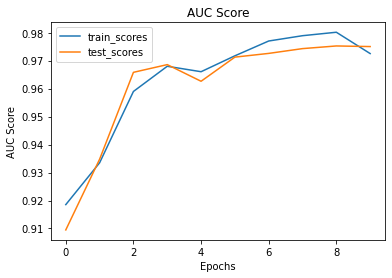

In [30]:
# plot training stats
train.plot_train_stats()

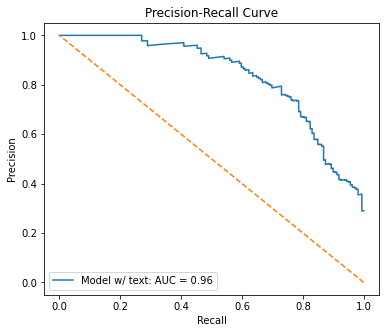

In [31]:
# plot pr curve
train.plot_pr_curve(X_test, y_test)

### Interpret the Model

#### Categorical and Numerical Features

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[16:15:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


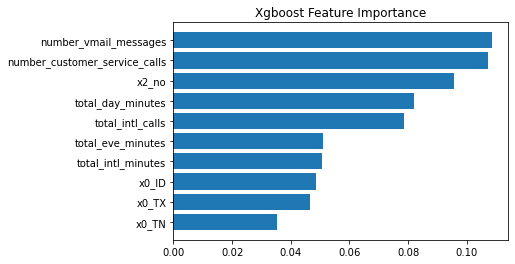

In [32]:
preds_xgb = interpret.train_xgb()

#### Textual Features (focus on customer chats that result in churn)

In [9]:
chats, df_sub = interpret.get_chats(df=df, churn=1, speaker='Customer')

In [10]:
chats[:3]

["Well, I just want to be able to cancel the contract because I don't think that I want to stay. My local provider has been terrible and I really would like to switch. Sure, I can.",
 "Well, it's the old TelCom billing system for the last 5 years. I don't trust anymore and I think you should change to the newer billing system. I would like to give you a call back number. Okay, I can see why you need the new billing system, but I don't know if I can do that. I would like to know your cancellation policy.",
 "Well, I've been getting phone calls from a very good friend who's a TelCom agent and I have told him the same thing and the problem has not been resolved. He has offered me a $20/mo deal but that's not good enough for me because I'm getting $20 out of his pocket. Sure. $60 to cancel for nine months with a $20/mo bonus."]

##### Candidate keywords (POS tagging, lower casing, lemmatization)

In [11]:
# find candidate keywords
keywords, tokens = interpret.get_keywords(chats)
print(keywords[:10])

# map keywords to original tokens
keywords_dict = interpret.map_to_orig_tok(keywords, tokens)

['want', 'able', 'cancel', 'contract', 'think', 'want', 'stay', 'local', 'provider', 'terrible']


##### Relevant keywords (semantic similarity)

In [12]:
relevant_keywords, simMat = interpret.get_relevant_keywords(
    text = chats, 
    keywords_dict = keywords_dict
)

In [13]:
print(relevant_keywords[:25])

['voicemail', 'bored', 'spam', 'backlog', 'sick', 'frustrated', 'incompetence', 'overcharge', 'angry', 'disappointed', 'scam', 'lag', 'termination', 'resign', 'nightmare', 'incompetent', 'frustration', 'lagging', 'yesterday', 'friday', 'monday', 'discontinue', 'cheat', 'dead', 'annoyed']


##### Impactful kewords (marginal contribution)

In [14]:
# get marginal contribution to prediction for each keyword
marg_contr_df = interpret.perform_ablation(
    df = df_sub,
    keywords = relevant_keywords,
    keywords_dict = keywords_dict
)

100%|██████████| 250/250 [11:25<00:00,  2.74s/it]


##### Create joint metric (semantic similarity + marginal contribution + count)

In [ ]:
# load from local disc if available
#results_df = pd.read_csv('model/ablation_results.csv')
#results_df = results_df.rename(columns={'Unnamed: 0' : 'keyword'})

In [15]:
results_df = interpret.get_important_keywords(
    simMat_df=simMat,
    marg_contr_df=marg_contr_df
)

In [16]:
results_df.head(20)

,keyword,sim,chg,count,joint
0,voicemail,90.076553,0.006695,5,0.628774
1,cancel,61.187359,-0.081321,168,0.545633
2,sick,74.789459,-0.127242,1,0.538919
3,turnover,60.896118,-0.286630,1,0.533321
4,disappointed,70.248131,-0.091740,5,0.522520
5,spam,77.940460,-0.000022,3,0.506429
6,bored,78.131271,-0.038932,1,0.502213
7,unhappy,65.601990,-0.024782,37,0.493910
8,frustrated,73.496033,-0.006023,5,0.486930
9,mistake,66.247879,-0.093309,3,0.470609


##### Context of keywords

In [17]:
keyword_of_interest = 'spam'

In [18]:
interpret.obtain_context(
    chats_list = chats,
    keyword = keyword_of_interest
)

Basically, I'm getting a lot of spam calls every day from a guy named Michael who's calling from a really weird number.
TelCom started to flood me with emails and phone calls, spamming me with thousands of phony invoices.
I just got some spam messages last night, and today it's been getting a lot of texts that I "don't have my SIM card" and "I need my SIM card.
